In [1]:
#Librerías básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Librerías para scrapear 
import requests
from bs4 import BeautifulSoup
from io import StringIO

#Librerías relacionadas con rutas
import os
import sys

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# TRATAMIENTO DE TABLAS

## Tabla de salarios

In [2]:
salaries_df = pd.read_csv("../data/raw/salaries.csv")
salaries_df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Associate,113000,USD,113000,CA,0,CA,M
1,2024,SE,FT,Associate,75000,USD,75000,CA,0,CA,M
2,2024,SE,FT,Research Scientist,208000,USD,208000,US,0,US,M
3,2024,SE,FT,Research Scientist,147000,USD,147000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,214500,USD,214500,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
59994,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
59995,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
59996,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
59997,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


Por lo que se nos indica en la fuente de la que se ha obtenido la información relativa a los salarios, los campos `salary_in_usd` y `salary` son análogos: uno viene expresado en dólares, mientras que el otro viene en la divisa que se indica en `salary_currency`. Nuestra variable a predecir es `salary_in_usd`, por lo que la otra podemos borrarla.

In [3]:
salaries_df.drop(columns=["salary"], inplace=True)

In [4]:
salaries_df.info() #No hay registros vacíos y hay campos tanto de tipo numérico como de tipo str

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59999 entries, 0 to 59998
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           59999 non-null  int64 
 1   experience_level    59999 non-null  object
 2   employment_type     59999 non-null  object
 3   job_title           59999 non-null  object
 4   salary_currency     59999 non-null  object
 5   salary_in_usd       59999 non-null  int64 
 6   employee_residence  59999 non-null  object
 7   remote_ratio        59999 non-null  int64 
 8   company_location    59999 non-null  object
 9   company_size        59999 non-null  object
dtypes: int64(3), object(7)
memory usage: 4.6+ MB


In [5]:
salaries_df.describe()

,work_year,salary_in_usd,remote_ratio
count,59999.000000,59999.000000,59999.000000
mean,2023.786763,159045.964883,22.177870
std,0.509777,72087.101137,41.408523
min,2020.000000,15000.000000,0.000000
25%,2024.000000,109100.000000,0.000000
50%,2024.000000,149000.000000,0.000000
75%,2024.000000,200000.000000,0.000000
max,2024.000000,800000.000000,100.000000


In [6]:
salaries_df.duplicated().value_counts() #Hay registros duplicados

True     31626
False    28373
Name: count, dtype: int64

In [7]:
#Borramos duplicados
salaries_df.drop_duplicates(inplace=True)
salaries_df.reset_index(inplace=True, drop=True)

In [8]:
salaries_df.describe()

,work_year,salary_in_usd,remote_ratio
count,28373.000000,28373.000000,28373.000000
mean,2023.728545,152403.360448,26.456490
std,0.594255,75684.533602,43.841405
min,2020.000000,15000.000000,0.000000
25%,2024.000000,98000.000000,0.000000
50%,2024.000000,141000.000000,0.000000
75%,2024.000000,192871.000000,100.000000
max,2024.000000,800000.000000,100.000000


### Análisis de la distribución del target

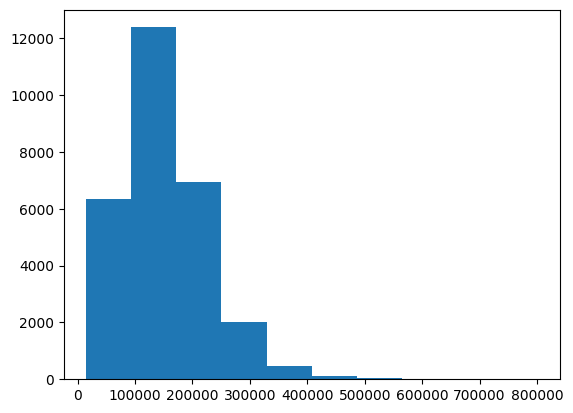

In [9]:
plt.hist(salaries_df["salary_in_usd"]);

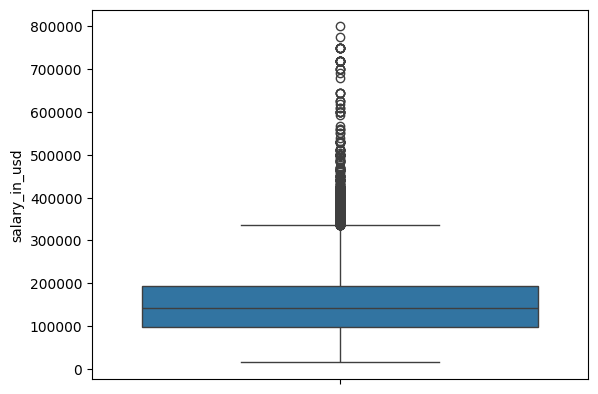

In [10]:
sns.boxplot(salaries_df["salary_in_usd"]);

La variable a predecir tiene una distribución asimétrica, además de tener numerosos outliers. Por ello, vamos a:
1. Aplicar una transformación logarítmica que mejore la simetría
2. Detectar los outliers y eliminarlos

In [11]:
salaries_df["salary_in_usd_log"] = np.log(salaries_df['salary_in_usd'])
salaries_df.drop(columns=["salary_in_usd"], inplace=True)

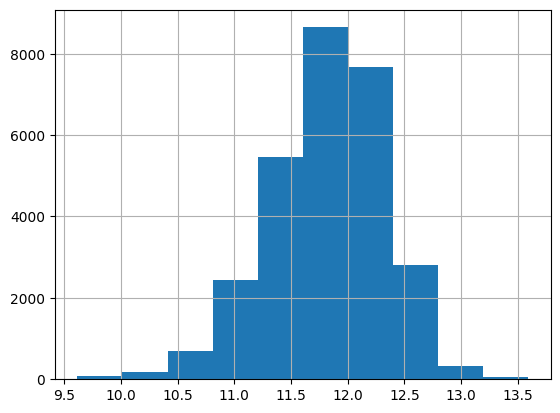

In [12]:
#La transformación logarítmica de los salarios presenta menos asimetría 
salaries_df["salary_in_usd_log"].hist();

In [13]:
os.chdir('..') # Vamos a la carpeta previa
sys.path.append(os.getcwd())
from src.drop_outliers import drop_outliers

In [14]:
#Borramos los registros para los que el salario es un outlier
drop_outliers(salaries_df, "salary_in_usd_log")

In [15]:
#Guardamos la tabla adaotada de los salarios
salaries_df.to_csv("data/processed/unique_salaries_log_outliers.csv", index=False)

## Tabla ISO

In [16]:
iso_df = pd.read_csv("data/raw/country_continent_ISO.csv")
iso_df

,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,Asia,South Asia,Afghanistan,Kabul,AF,AF,AFG,4.0,AF,NaN
1,Europe,South East Europe,Albania,Tirana,AL,AL,ALB,8.0,AL,NaN
2,Africa,Northern Africa,Algeria,Algiers,AG,DZ,DZA,12.0,DZ,NaN
3,Oceania,Pacific,American Samoa,Pago Pago,AQ,AS,ASM,16.0,AS,NaN
4,Europe,South West Europe,Andorra,Andorra la Vella,AN,AD,AND,20.0,AD,NaN
...,...,...,...,...,...,...,...,...,...,...
227,Oceania,Pacific,Western Samoa,Apia,WS,WS,WSM,882.0,WS,NaN
228,Asia,South West Asia,Yemen,Sanaa,YM,YE,YEM,887.0,YE,NaN
229,Africa,Central Africa,Zaire (Dem Rep of Congo),Kinshasa,CG,ZR,ZAR,180.0,ZR,8.0
230,Africa,Southern Africa,Zambia,Lusaka,ZA,ZM,ZWB,894.0,ZM,NaN


In [17]:
#Borramos las columnas que no necesitamos
iso_df.drop(columns=["FIPS", "ISO (No)", "Internet", "Note" ], inplace=True)

In [18]:
iso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  232 non-null    object
 1   Region     232 non-null    object
 2   Country    232 non-null    object
 3   Capital    231 non-null    object
 4   ISO (2)    231 non-null    object
 5   ISO (3)    232 non-null    object
dtypes: object(6)
memory usage: 11.0+ KB


## Join de tabla de salarios con tabla ISO

### Para el company_location

In [19]:
#Hacemos un left join de la tabla de salarios con la de los códigos ISO de los países
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="company_location", right_on="ISO (2)")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,Continent,Region,Country,Capital,ISO (2),ISO (3)
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28011,2020,SE,FT,Data Scientist,USD,US,100,US,L,12.928779,Americas,North America,United States,"Washington, DC",US,USA
28012,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,11.925035,Americas,North America,United States,"Washington, DC",US,USA
28013,2020,EN,FT,Data Scientist,USD,US,100,US,S,11.561716,Americas,North America,United States,"Washington, DC",US,USA
28014,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,11.512925,Americas,North America,United States,"Washington, DC",US,USA


In [20]:
#Renombramos columnas
salaries_df.rename(columns={"Continent":"company_continent", 
                    "Region":"company_region",
                    "Country":"company_country",
                    "Capital":"company_capital"}, inplace=True)

In [21]:
#Comprobamos si hay algún país de la tabla de salarios que no haya cruzado con la de los códigos ISO
salaries_df[salaries_df["company_continent"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,company_continent,company_region,company_country,company_capital,ISO (2),ISO (3)
19278,2024,SE,FT,Data Analyst,USD,RS,100,RS,M,10.896739,NaN,NaN,NaN,NaN,NaN,NaN
19279,2024,SE,FT,Data Analyst,USD,RS,100,RS,M,10.778956,NaN,NaN,NaN,NaN,NaN,NaN
26084,2023,MI,FT,Data Scientist,HKD,HK,0,HK,L,11.083034,NaN,NaN,NaN,NaN,NaN,NaN


Si nos fijamos en el output previo, vemos que hay tres registros para los que la tabla de salarios no ha cruzado con la de los códigos ISO:
- RS se corresponde con Serbia (Europa)
- HK se corresponde con Hong Kong (Asia)

Corregimos estos casos en la tabla original de los códigos ISO, para así arreglarlo en el origen.

SERBIA

In [22]:
iso_df[iso_df["Country"].str.contains("Serbia")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)
183,Europe,South East Europe,Serbia and Montenegro,Belgrade / Podgorica,--,--


In [23]:
iso_df.loc[iso_df[iso_df["Country"].str.contains("Serbia")].index[0], "ISO (2)"] = "RS"

In [24]:
iso_df.loc[iso_df[iso_df["Country"].str.contains("Serbia")].index[0], "ISO (3)"] = "SRB"

HONG KONG

In [25]:
iso_df[iso_df["Country"].str.contains("Hong")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)


In [26]:
iso_df[iso_df["Country"].str.upper().str.contains("HONG")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)


In [27]:
#Hong Kong no estaba incluido en la tabla de los códigos ISO así que lo incluimos
hk = {"Continent":["Asia"], "Region": ["East Asia"], "Country": ["Hong Kong"], "Capital": ["-"], "ISO (2)": ["HK"], "ISO (3)":["HKG"]}
iso_df = pd.concat([iso_df, pd.DataFrame(hk)], axis=0, ignore_index = True)

In [28]:
#Guardamos la tabla corregida
iso_df.to_csv("data/processed/country_continent_ISO_fixed.csv", index=False)

In [29]:
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,company_continent,company_region,company_country,company_capital,ISO (2),ISO (3)
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28011,2020,SE,FT,Data Scientist,USD,US,100,US,L,12.928779,Americas,North America,United States,"Washington, DC",US,USA
28012,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,11.925035,Americas,North America,United States,"Washington, DC",US,USA
28013,2020,EN,FT,Data Scientist,USD,US,100,US,S,11.561716,Americas,North America,United States,"Washington, DC",US,USA
28014,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,11.512925,Americas,North America,United States,"Washington, DC",US,USA


In [30]:
#Borramos las columnas de los códigos ISO previamente incluidas en la de salarios mediante el join
salaries_df = salaries_df.iloc[:,:10]

In [31]:
#Hacemos de nuevo el join de las tablas
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="company_location", right_on="ISO (2)")

In [32]:
#Renombramos de nuevo las columnas
salaries_df.rename(columns={"Continent":"company_continent", 
                    "Region":"company_region",
                    "Country":"company_country",
                    "Capital":"company_capital"}, inplace=True)

### Para el employee_residence

In [33]:
#Hacemos un left join de la tabla de salarios con la de los códigos ISO de los países, ahora para el campo de residencias de los empleados
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="employee_residence", right_on="ISO (2)")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,...,company_country,company_capital,ISO (2)_x,ISO (3)_x,Continent,Region,Country,Capital,ISO (2)_y,ISO (3)_y
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,...,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,...,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28011,2020,SE,FT,Data Scientist,USD,US,100,US,L,12.928779,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
28012,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,11.925035,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
28013,2020,EN,FT,Data Scientist,USD,US,100,US,S,11.561716,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA
28014,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,11.512925,...,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA


In [34]:
#Renombramos columnas
salaries_df.rename(columns={"Continent":"employee_continent", 
                    "Region":"employee_region",
                    "Country":"employee_country",
                    "Capital":"employee_capital",
                    "ISO (2)_x":"company_iso2",
                    "ISO (3)_x":"company_iso3",
                    "ISO (2)_y":"employee_iso2",
                    "ISO (3)_y":"employee_iso3"}, inplace=True)

In [35]:
#Comprobamos si hay algún país de la tabla de salarios que, para los empleados, no haya cruzado con la de los códigos ISO
salaries_df[salaries_df["employee_continent"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,...,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3
27913,2021,EN,FT,Research Scientist,USD,JE,0,CN,L,11.512925,...,China,Beijing,CN,CHN,NaN,NaN,NaN,NaN,NaN,NaN


Si nos fijamos en el output previo, vemos que hay un registro para el que la tabla de salarios no ha cruzado con la de los códigos ISO:

- JE se corresponde con Jersey (Europa)

Corregimos este caso en la tabla original de los códigos ISO, para así arreglarlo en el origen.

In [36]:
iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")]

,Continent,Region,Country,Capital,ISO (2),ISO (3)
103,Europe,Western Europe,Jersey,Saint Helier,--,--


In [37]:
iso_df.loc[iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")].index[0], "ISO (2)"] = "JE"
iso_df.loc[iso_df[iso_df["Country"].str.upper().str.contains("JERSEY")].index[0], "ISO (3)"] = "JEY"

In [38]:
#Guardamos la tabla corregida
iso_df.to_csv("data/processed/country_continent_ISO_fixed.csv", index=False)

In [39]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28016 entries, 0 to 28015
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           28016 non-null  int64  
 1   experience_level    28016 non-null  object 
 2   employment_type     28016 non-null  object 
 3   job_title           28016 non-null  object 
 4   salary_currency     28016 non-null  object 
 5   employee_residence  28016 non-null  object 
 6   remote_ratio        28016 non-null  int64  
 7   company_location    28016 non-null  object 
 8   company_size        28016 non-null  object 
 9   salary_in_usd_log   28016 non-null  float64
 10  company_continent   28016 non-null  object 
 11  company_region      28016 non-null  object 
 12  company_country     28016 non-null  object 
 13  company_capital     28016 non-null  object 
 14  company_iso2        28016 non-null  object 
 15  company_iso3        28016 non-null  object 
 16  empl

In [40]:
#Borramos las columnas de los códigos ISO previamente incluidas en la de salarios mediante el join
salaries_df = salaries_df.iloc[:,:16]

In [41]:
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,company_continent,company_region,company_country,company_capital,company_iso2,company_iso3
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,Americas,North America,Canada,Ottawa,CA,CAN
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,Americas,North America,Canada,Ottawa,CA,CAN
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,Americas,North America,United States,"Washington, DC",US,USA
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,Americas,North America,United States,"Washington, DC",US,USA
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,Americas,North America,United States,"Washington, DC",US,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28011,2020,SE,FT,Data Scientist,USD,US,100,US,L,12.928779,Americas,North America,United States,"Washington, DC",US,USA
28012,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,11.925035,Americas,North America,United States,"Washington, DC",US,USA
28013,2020,EN,FT,Data Scientist,USD,US,100,US,S,11.561716,Americas,North America,United States,"Washington, DC",US,USA
28014,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,11.512925,Americas,North America,United States,"Washington, DC",US,USA


In [42]:
#Hacemos el left join de nuevo
salaries_df = pd.merge(left=salaries_df, right=iso_df, how="left", left_on="employee_residence", right_on="ISO (2)")

#Renombramos de nuevo las columnas
salaries_df.rename(columns={"Continent":"employee_continent", 
                    "Region":"employee_region",
                    "Country":"employee_country",
                    "Capital":"employee_capital",
                    "ISO (2)":"employee_iso2",
                    "ISO (3)":"employee_iso3"}, inplace=True)

## Tabla de PIB

In [43]:
pib_df = pd.read_csv("data/raw/API_NY.GDP.MKTP.KD_DS2_es_csv_v2_2115/API_NY.GDP.MKTP.KD_DS2_es_csv_v2_2115.csv", header=2)
pib_df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,3.013858e+09,3.226291e+09,3.303132e+09,3.227067e+09,2.453133e+09,3.131163e+09,3.458630e+09,NaN,NaN
1,NaN,AFE,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,1.528011e+11,1.535042e+11,1.655819e+11,1.748817e+11,1.830454e+11,1.924521e+11,...,8.992957e+11,9.189325e+11,9.432971e+11,9.685937e+11,9.897987e+11,9.622785e+11,1.005556e+12,1.041298e+12,1.068604e+12,NaN


In [44]:
pib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            141 non-null    float64
 5   1961            149 non-null    float64
 6   1962            149 non-null    float64
 7   1963            149 non-null    float64
 8   1964            149 non-null    float64
 9   1965            153 non-null    float64
 10  1966            157 non-null    float64
 11  1967            159 non-null    float64
 12  1968            159 non-null    float64
 13  1969            159 non-null    float64
 14  1970            182 non-null    float64
 15  1971            182 non-null    float64
 16  1972            182 non-null    float64
 17  1973            182 non-null    flo

- Esta tabla contiene el PIB de cada país desde 1960 hasta 2023 en dólares, a precio constante desde 2015. No obstante, para algunos países no está la información correspondiente a cada uno de esos años. Por ello, vamos a calcular la media del PIB de cada uno de de los países, siendo este el valor que usaremos para cada país. (Es decir, puesto que cada registro representa un país, vamos a calcular la media a nivel registro, para así tener el PIB medio de cada sitio)

- La última columna está completamente vacía, por lo que también la eliminaremos.

- Para evitar fallos, a los dos registros que tienen el nombre del país sin informar los vamos a indicar como desconocidos

In [45]:
#Indicamos como desconocidos los países con nombre vacío
pib_df["Country Name"].fillna("Unknown", inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_8888\3910946890.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pib_df["Country Name"].fillna("Unknown", inplace=True)


In [46]:
#Eliminamos la columna de nulos
pib_df.drop(columns=["Unnamed: 68"], inplace=True)

In [47]:
#Definición de una columna nueva con la media de los PIBs
mean_pib =[]
for i in range(len(pib_df)):
    mean_pib.append(pib_df.iloc[i, 4:].mean())
mean_pib

[2596102515.182239,
 488925744841.86316,
 14180778311.558445,
 369343120022.4958,
 49406326429.60504,
 7907615249.208133,
 2071126646.6813192,
 1390095083183.8687,
 201701604995.3439,
 359259016486.8221,
 7720264584.694791,
 684204434.7509997,
 1098519943.987956,
 754979901077.8411,
 254513743758.84842,
 32343960647.55812,
 2021470070.9625669,
 307562248674.5804,
 5913931042.446471,
 5426671266.879408,
 91382859476.2858,
 41807474718.66812,
 16552140003.193941,
 8012584232.085949,
 12524533667.608826,
 41572776710.00868,
 1052544698.6857731,
 5156205890.2028055,
 17030555149.407413,
 1023314980970.2665,
 3696240101.7403207,
 11088267816.617077,
 934175767.9805629,
 6490094636.56399,
 1559480493.5385435,
 961131567709.3438,
 1062450479229.0648,
 479952365875.401,
 nan,
 115482044676.85919,
 3837071247897.453,
 27124579989.88643,
 17462371643.088657,
 27516306725.936344,
 5931814638.740941,
 148242244548.23453,
 716135069.4731555,
 1039906346.1533939,
 27668048489.16656,
 23025498603.872

In [48]:
pib_df["mean_pib"] = mean_pib

In [49]:
pib_df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,mean_pib
0,Aruba,ABW,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,3.013858e+09,3.226291e+09,3.303132e+09,3.227067e+09,2.453133e+09,3.131163e+09,3.458630e+09,NaN,2.596103e+09
1,Unknown,AFE,PIB (US$ a precios constantes de 2015),NY.GDP.MKTP.KD,1.528011e+11,1.535042e+11,1.655819e+11,1.748817e+11,1.830454e+11,1.924521e+11,...,8.992957e+11,9.189325e+11,9.432971e+11,9.685937e+11,9.897987e+11,9.622785e+11,1.005556e+12,1.041298e+12,1.068604e+12,4.889257e+11


In [50]:
#Borramos todas las columnas de la tabla previa a excepción de: nombre del país, código del país y media del PIB
pib_df = pib_df.iloc[:,[0,1,-1]]
pib_df.head(2)

,Country Name,Country Code,mean_pib
0,Aruba,ABW,2.596103e+09
1,Unknown,AFE,4.889257e+11


In [51]:
#Guardamos la tabla adaptada
pib_df.to_csv("data/processed/mean_pib_per_country.csv", index=False)

## Join de tabla de salarios con tabla PIB

Vamos a hacer el join de la tabla de salarios con la del PIB para la columna correspondiente a la localización de la compañía

In [52]:
#Hacemos un left join de la tabla de salarios con la de las medias del pib
salaries_df = pd.merge(left=salaries_df, right=pib_df, how="left", left_on= 'company_iso3', right_on= "Country Code")
salaries_df

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,...,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,...,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,...,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28011,2020,SE,FT,Data Scientist,USD,US,100,US,L,12.928779,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
28012,2021,MI,FT,Principal Data Scientist,USD,US,100,US,L,11.925035,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
28013,2020,EN,FT,Data Scientist,USD,US,100,US,S,11.561716,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13
28014,2020,EN,CT,Business Data Analyst,USD,US,100,US,L,11.512925,...,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13


In [53]:
#Vamos a ver si tenemos algún país para el que no se haya realizado correctamente el join y su pib aparezca vacío
salaries_df[salaries_df["mean_pib"].isna()][["company_country", "company_iso3"]]

,company_country,company_iso3
16044,Romania,ROM
16114,Venezuela,VEN
16115,Venezuela,VEN
23858,Gibraltar,GIB
23983,Romania,ROM
26648,Romania,ROM
27808,Romania,ROM


Si nos fijamos en el output previo, vemos que hay varios países que no han cruzado: Rumanía, Venezuela y Gibraltar. Vamos a corregir esto en la tabla del PIB, para así tenerlo unificado con los códigos de la tabla de ISO que estamos trabajando.

RUMANÍA

In [54]:
pib_df[pib_df["Country Name"].str.upper().str.contains("RUMAN")]

,Country Name,Country Code,mean_pib
201,Rumania,ROU,1.488480e+11


In [55]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("RUMAN")].index[0], "Country Code"] = "ROM"

VENEZUELA

In [56]:
pib_df[pib_df["Country Name"].str.upper().str.contains("VENEZ")]

,Country Name,Country Code,mean_pib
254,Venezuela,VEN,NaN


No disponemos del PIB de Venezuela, por lo que vamos a asignarle el valor de **92210 millones de USD**, el cual hemos obtenido de [aquí](https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_PIB_(nominal))

In [57]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("VENEZ")].index[0],"mean_pib"] = 92210000000

GIBRALTAR

In [58]:
pib_df[pib_df["Country Name"].str.upper().str.contains("GIBRAL")]

,Country Name,Country Code,mean_pib
84,Gibraltar,GIB,NaN


Tampoco disponemos del PIB de Gibraltar, por lo que vamos a asignarle el valor de **2044 millones de USD**, el cual hemos obtenido de [aquí](https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_PIB_(nominal))

In [59]:
pib_df.loc[pib_df[pib_df["Country Name"].str.upper().str.contains("GIBRAL")].index[0],"mean_pib"] = 2044000000

In [60]:
#Actualizamos la tabla del PIB
pib_df.to_csv("data/processed/mean_pib_per_country.csv", index=False)

In [61]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28016 entries, 0 to 28015
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           28016 non-null  int64  
 1   experience_level    28016 non-null  object 
 2   employment_type     28016 non-null  object 
 3   job_title           28016 non-null  object 
 4   salary_currency     28016 non-null  object 
 5   employee_residence  28016 non-null  object 
 6   remote_ratio        28016 non-null  int64  
 7   company_location    28016 non-null  object 
 8   company_size        28016 non-null  object 
 9   salary_in_usd_log   28016 non-null  float64
 10  company_continent   28016 non-null  object 
 11  company_region      28016 non-null  object 
 12  company_country     28016 non-null  object 
 13  company_capital     28016 non-null  object 
 14  company_iso2        28016 non-null  object 
 15  company_iso3        28016 non-null  object 
 16  empl

In [62]:
#Borramos las columnas los PIB medios de cada país, para volver a hacer el join con la tabla del PIB arreglada
salaries_df = salaries_df.iloc[:,:22]

In [63]:
#Hacemos de nuevo el left join de la tabla de salarios con la de las medias del pib
salaries_df = pd.merge(left=salaries_df, right=pib_df, how="left", left_on= 'company_iso3', right_on= "Country Code")

## Tasa de desempleo

In [64]:
unemployment_df = pd.read_csv("data/raw/unemployment-rate-imf/unemployment-rate-imf.csv")
unemployment_df

,Entity,Code,Year,Unemployment rate - Percent of total labor force - Observations,Unemployment rate - Percent of total labor force - Forecasts
0,Albania,ALB,1980,5.028,NaN
1,Albania,ALB,1981,4.224,NaN
2,Albania,ALB,1982,2.813,NaN
3,Albania,ALB,1983,3.335,NaN
4,Albania,ALB,1984,4.410,NaN
...,...,...,...,...,...
4626,Vietnam,VNM,2025,NaN,2.030
4627,Vietnam,VNM,2026,NaN,1.998
4628,Vietnam,VNM,2027,NaN,1.965
4629,Vietnam,VNM,2028,NaN,1.933


En este dataset hay información sobre el ratio (observado) de desempleo desde el año 1980 hasta el 2023, además de las previsiones a corto plazo. Para nuestro caso, nosotros vamos a quedarnos sólo, de entre las observadas y no las previstas, con las más recientes. Para más información y contexto acerca de estos datos, leer [esto](../data/raw/unemployment-rate-imf/readme.md).

In [65]:
#Toda la información que hay a partir del año 2024 se tratan de previsiones
unemployment_df[unemployment_df["Year"].isin([2024, 2025, 2026, 2027, 2028, 2029])]["Unemployment rate - Percent of total labor force - Observations"].value_counts()

Series([], Name: count, dtype: int64)

In [66]:
unemployment_df.drop(index=unemployment_df[unemployment_df["Year"].isin([2024, 2025, 2026, 2027, 2028, 2029])].index, inplace=True) #Borramos los datos desde el año 2024 en adelante
unemployment_df.reset_index(drop=True, inplace=True) #Reseteamos los índices

In [67]:
unemployment_df.sort_values(by="Year", ascending=False, inplace=True) #Ordenamos de mayor a menor año
unemployment_df.reset_index(drop=True, inplace=True) #Reseteamos los índices

In [68]:
#Eliminamos la columna de las previsiones
unemployment_df = unemployment_df.iloc[:, :-1]

In [69]:
unemployment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 4 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Entity                                                           4037 non-null   object 
 1   Code                                                             3993 non-null   object 
 2   Year                                                             4037 non-null   int64  
 3   Unemployment rate - Percent of total labor force - Observations  3945 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 126.3+ KB


In [70]:
unemployment_df["Entity"].value_counts()

Entity
Turkey        44
Chile         44
Australia     44
Canada        44
Panama        44
              ..
Brunei        13
Tajikistan    13
Kosovo        11
Nigeria        9
China          7
Name: count, Length: 114, dtype: int64

Tal y como se puede ver en las celdas previas, como hay países para los que no se conoce la tasa de desempleo, y están repetidos, vamos a quedarnos sólo con el último valor conocido para cada uno de ellos.

In [71]:
unemployment_df = unemployment_df[~(unemployment_df["Unemployment rate - Percent of total labor force - Observations"].isna())] #Nos quedamos sólo con los registros con tasa de desempleo informada
unemployment_df.drop_duplicates(subset=["Entity"], keep="first", inplace=True, ignore_index=True) 
#Borramos registros duplicados, quedándonos sólo con la 1ª aparición de cada país (puesto que hemos ordenado previamente por los años de forma descendente 
#y ya hemos borrado los registros sin tasa de desempleo informada)

## Join de tabla de salarios con tabla de tasa de desempleo

Vamos a hacer el join de la tabla de salarios con la de la tasa de desempleo para la columna correspondiente a la localización de la compañía.

In [72]:
salaries_df = pd.merge(left=salaries_df, right=unemployment_df, how="left", left_on="company_iso3", right_on="Code")

In [73]:
salaries_df.rename(columns={"Unemployment rate - Percent of total labor force - Observations": "unemployment_rate"}, inplace=True)

In [74]:
#Vamos a ver si tenemos algún país para el que no esté informada la tasa de desempleo
salaries_df[salaries_df["unemployment_rate"].isna()]

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,...,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib,Entity,Code,Year,unemployment_rate
782,2024,SE,FT,Data Lead,USD,LB,0,LB,M,12.254863,...,Beirut,LB,LBN,Líbano,LBN,3.232416e+10,NaN,NaN,NaN,NaN
783,2024,SE,FT,Data Lead,USD,LB,0,LB,M,11.715866,...,Beirut,LB,LBN,Líbano,LBN,3.232416e+10,NaN,NaN,NaN,NaN
4322,2024,SE,FT,Data Manager,USD,KE,0,KE,M,11.207758,...,Nairobi,KE,KEN,Kenya,KEN,3.567740e+10,NaN,NaN,NaN,NaN
4323,2024,SE,FT,Data Manager,USD,KE,0,KE,M,10.920528,...,Nairobi,KE,KEN,Kenya,KEN,3.567740e+10,NaN,NaN,NaN,NaN
6473,2024,SE,FT,Data Analyst,USD,IN,0,IN,M,11.951180,...,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27810,2021,EN,FT,Machine Learning Developer,USD,IQ,50,IQ,S,11.512925,...,Baghdad,IQ,IRQ,Iraq,IRQ,7.074971e+10,NaN,NaN,NaN,NaN
27899,2020,MI,FT,Lead Data Scientist,USD,AE,0,AE,L,11.652687,...,Abu Dhabi,AE,ARE,Emiratos Árabes Unidos,ARE,2.017016e+11,NaN,NaN,NaN,NaN
27928,2021,SE,FT,Machine Learning Engineer,INR,IN,0,IN,L,11.101417,...,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN,NaN,NaN
27942,2020,MI,FT,Data Scientist,INR,IN,0,IN,L,10.608588,...,New Delhi,IN,IND,India,IND,8.776548e+11,NaN,NaN,NaN,NaN


In [75]:
salaries_df[salaries_df["unemployment_rate"].isna()]["Entity"].isna().value_counts()

Entity
True    79
Name: count, dtype: int64

Tal y como vemos en la anterior celda, hay países para los que no tenemos tasa de desempleo, lo cual no se debe a un cruce incorrecto sino porque nuestra tabla "maestra" de la que obtener la tasa de desempleo no tiene la información de todos los países. A continuación, vemos para cuántos países ocurre esto:

In [76]:
salaries_df[salaries_df["unemployment_rate"].isna()]["company_iso3"].value_counts()

company_iso3
IND    44
LBN     8
KEN     5
ARE     5
ROM     4
KOR     4
ASM     2
CAF     2
OMN     1
GIB     1
QAT     1
GHA     1
IRQ     1
Name: count, dtype: int64

Fijándonos en el anterior output, vemos que:

- 44 puestos de trabajo son relativos a una compañía con sede en India
- 8 puestos de trabajo son relativos a una compañía con sede en Líbano

El resto de los países con tasa de desempleo sin informar constituyen una muy pequeña parte del total de registros de la tabla, por lo que vamos a borrarlos. Para los casos de India y Líbano, los hemos buscado en la página [Trading Economics](https://es.tradingeconomics.com/):

- [Tasa de desempleo de IND](https://es.tradingeconomics.com/india/unemployment-rate) ==> 7.8
- [Tasa de desempleo de LBN](https://es.tradingeconomics.com/lebanon/unemployment-rate) ==> 11.7

In [77]:
salaries_df.loc[salaries_df[salaries_df["company_iso3"] == "IND"].index.to_list(),"unemployment_rate"] = 7.8
salaries_df.loc[salaries_df[salaries_df["company_iso3"] == "LBN"].index.to_list(),"unemployment_rate"] = 11.7

In [78]:
#Borramos los registros de países para los que no conocemos la tasa de desempleo
salaries_df.dropna(subset="unemployment_rate", inplace=True) 
salaries_df.reset_index(drop=True, inplace=True)

# BORRAMOS COLUMNAS INNECESARIAS

Por los diversos joins que hemos ido haciendo, tenemos columnas duplicadas. Así pues, vamos a echar un vistazo rápido a todas ellas para ver cuáles podemos eliminar.

In [79]:
pd.options.display.max_columns = None
salaries_df.head(5)

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd_log,company_continent,company_region,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,Country Name,Country Code,mean_pib,Entity,Code,Year,unemployment_rate
0,2024,SE,FT,Associate,USD,CA,0,CA,M,11.635143,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11,Canada,CAN,2023.0,5.408
1,2024,SE,FT,Associate,USD,CA,0,CA,M,11.225243,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,Canadá,CAN,9.611316e+11,Canada,CAN,2023.0,5.408
2,2024,SE,FT,Research Scientist,USD,US,0,US,M,12.245293,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,United States,USA,2023.0,3.625
3,2024,SE,FT,Research Scientist,USD,US,0,US,M,11.898188,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,United States,USA,2023.0,3.625
4,2024,SE,FT,Machine Learning Engineer,USD,US,0,US,M,12.276065,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,Estados Unidos,USA,1.111938e+13,United States,USA,2023.0,3.625


In [80]:
#Borramos columnas innecesarias por estar duplicadas
salaries_df.drop(columns=["employee_residence", "company_location", "Country Name", "Country Code", "Entity", "Code", "Year"], inplace=True)

# MAPA DE CALOR (I)

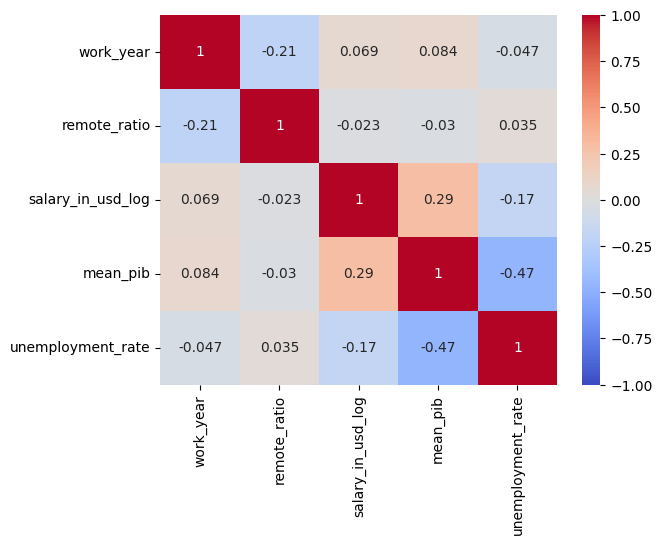

In [81]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

# TRATAMIENTO DE VARIABLES CATEGÓRICAS (I)

In [82]:
salaries_df.head(3)

,work_year,experience_level,employment_type,job_title,salary_currency,remote_ratio,company_size,salary_in_usd_log,company_continent,company_region,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,mean_pib,unemployment_rate
0,2024,SE,FT,Associate,USD,0,M,11.635143,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,5.408
1,2024,SE,FT,Associate,USD,0,M,11.225243,Americas,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,5.408
2,2024,SE,FT,Research Scientist,USD,0,M,12.245293,Americas,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,3.625


## 1. experience_level

In [83]:
salaries_df["experience_level"].replace({"EN":1,
                               "MI":2,
                               "SE":3,
                               "EX":4

}, inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_8888\3695592884.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  salaries_df["experience_level"].replace({"EN":1,
C:\Users\tamar\AppData\Local\Temp\ipykernel_8888\3695592884.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  salaries_df["experience_lev

### Mapa de calor (II)

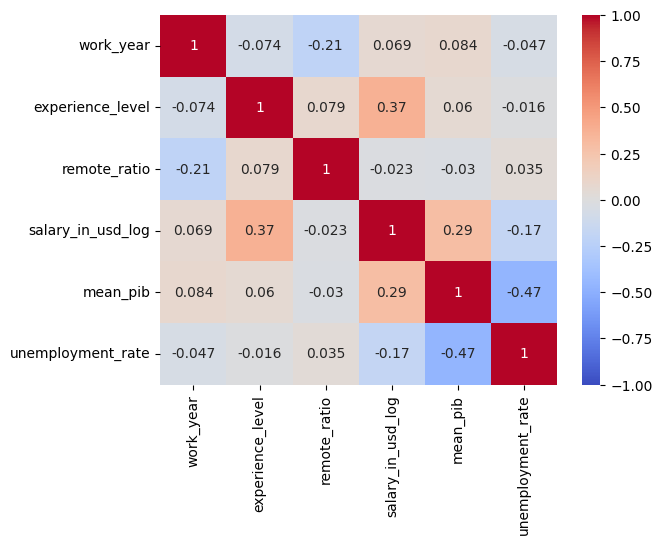

In [84]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 2. company_size

In [85]:
salaries_df["company_size"].value_counts()

company_size
M    26930
L      898
S      161
Name: count, dtype: int64

In [86]:
salaries_df["company_size"].replace({"S":1,
                               "M":2,
                               "L":3

}, inplace=True)

C:\Users\tamar\AppData\Local\Temp\ipykernel_8888\985676451.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  salaries_df["company_size"].replace({"S":1,
C:\Users\tamar\AppData\Local\Temp\ipykernel_8888\985676451.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  salaries_df["company_size"].replac

### Mapa de calor (III)

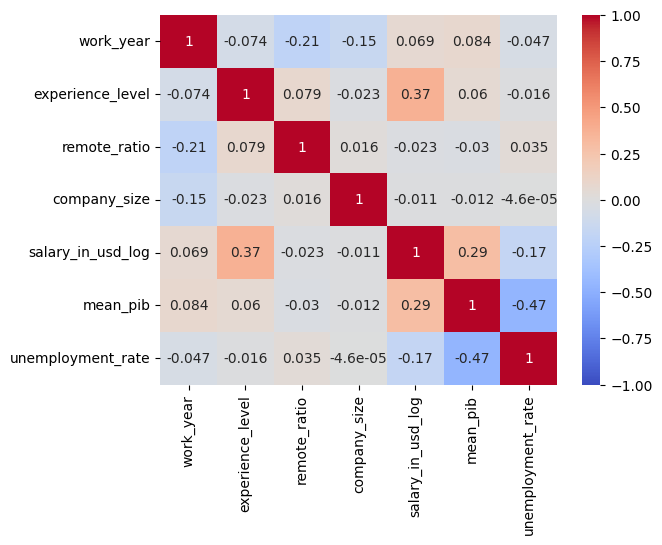

In [87]:
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 3. employment_type

In [88]:
salaries_df["employment_type"].value_counts()

employment_type
FT    27799
CT       90
PT       89
FL       11
Name: count, dtype: int64

In [89]:
#Aplicamos un get dummies para poder ver la correlación de cada uno de los tipos de empleo con el salario
emp_type_dummies = pd.get_dummies(salaries_df["employment_type"], dtype=int)
emp_type_dummies.rename(columns={"CT": "contract",
                         "FL":"freelance",
                         "FT":"full_time",
                         "PT":"part_time"
                         }, inplace=True)
salaries_df = pd.concat([salaries_df, emp_type_dummies], axis=1)

In [90]:
salaries_df.drop(columns=["employment_type"], inplace=True) #Borramos la columna del tipo de empleo, pues esta información está en las dummies previamente creadas

### Mapa de calor (IV)

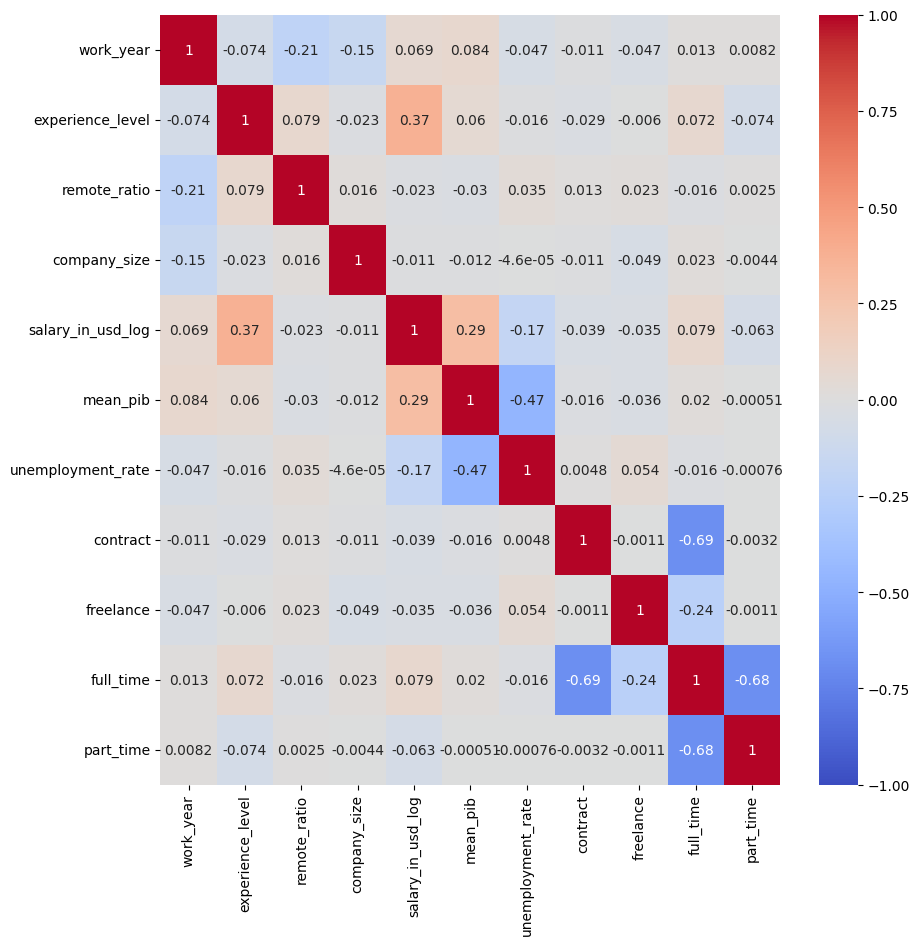

In [91]:
plt.figure(figsize=(10,10))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## 4. company_continent

In [92]:
salaries_df["company_continent"].value_counts()

company_continent
Americas    25574
Europe       2044
Oceania       172
Asia          126
Africa         73
Name: count, dtype: int64

In [93]:
#Aplicamos un get dummies para poder ver la correlación del continente en el que está la compañia y el salario
comp_cont_dummies = pd.get_dummies(salaries_df["company_continent"], dtype=int, prefix="company_")
salaries_df = pd.concat([salaries_df, comp_cont_dummies], axis=1)

#Borramos la columna original de la que hemos sacado las dummies previamente creadas
salaries_df.drop(columns=["company_continent"], inplace=True)

### Mapa de calor (V)

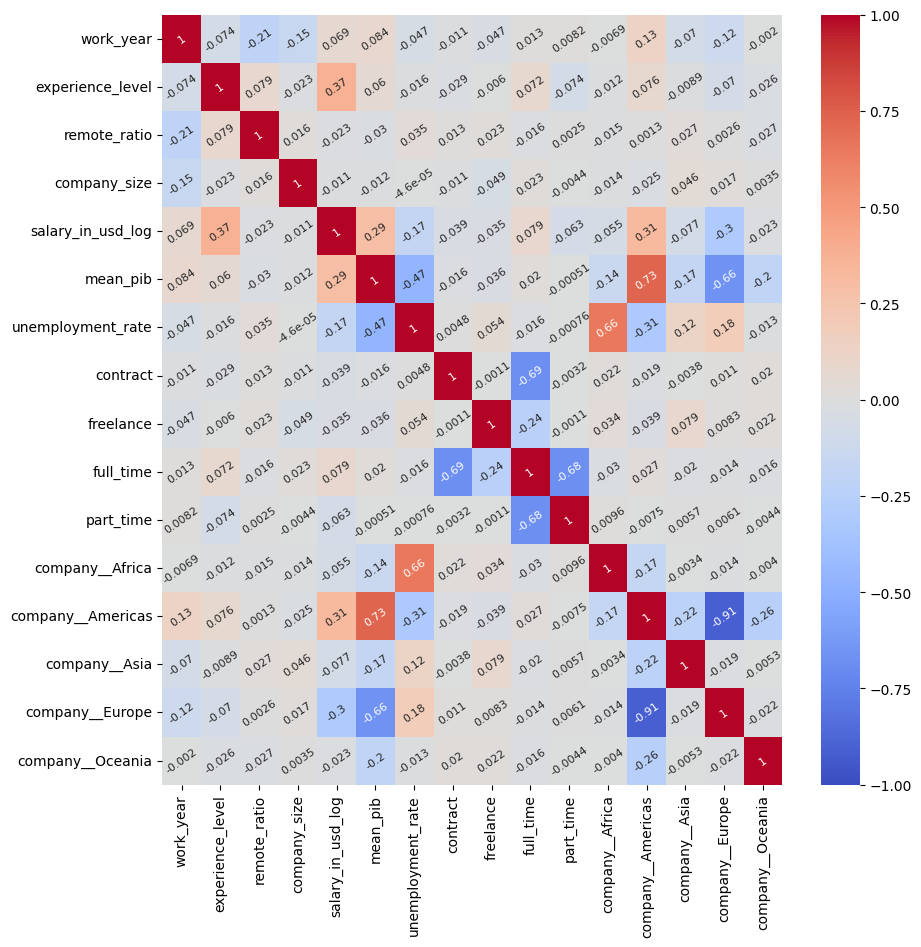

In [94]:
plt.figure(figsize=(10,10))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, cmap="coolwarm");

In [95]:
salaries_df.head()

,work_year,experience_level,job_title,salary_currency,remote_ratio,company_size,salary_in_usd_log,company_region,company_country,company_capital,company_iso2,company_iso3,employee_continent,employee_region,employee_country,employee_capital,employee_iso2,employee_iso3,mean_pib,unemployment_rate,contract,freelance,full_time,part_time,company__Africa,company__Americas,company__Asia,company__Europe,company__Oceania
0,2024,3,Associate,USD,0,2,11.635143,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,5.408,0,0,1,0,0,1,0,0,0
1,2024,3,Associate,USD,0,2,11.225243,North America,Canada,Ottawa,CA,CAN,Americas,North America,Canada,Ottawa,CA,CAN,9.611316e+11,5.408,0,0,1,0,0,1,0,0,0
2,2024,3,Research Scientist,USD,0,2,12.245293,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,3.625,0,0,1,0,0,1,0,0,0
3,2024,3,Research Scientist,USD,0,2,11.898188,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,3.625,0,0,1,0,0,1,0,0,0
4,2024,3,Machine Learning Engineer,USD,0,2,12.276065,North America,United States,"Washington, DC",US,USA,Americas,North America,United States,"Washington, DC",US,USA,1.111938e+13,3.625,0,0,1,0,0,1,0,0,0


## 5. job_title

In [96]:
pd.set_option("display.max_rows", None)
salaries_df["job_title"].value_counts().sort_values(ascending=False)

job_title
Data Scientist                               3827
Data Engineer                                3544
Data Analyst                                 2895
Machine Learning Engineer                    1937
Software Engineer                            1749
Engineer                                     1325
Manager                                       958
Research Scientist                            784
Analytics Engineer                            629
Data Architect                                592
Analyst                                       528
Research Engineer                             483
Product Manager                               424
Associate                                     397
Business Intelligence Analyst                 334
AI Engineer                                   328
Applied Scientist                             318
Data Manager                                  304
Data Specialist                               234
Research Analyst                        

In [112]:
# Reseteamos la configuración para no ver todas las filas
pd.reset_option('display.max_rows', 0)

Si nos fijamos en el output previo, vemos que hay unos puestos que predominan en cantidad frente al resto. Por ello, vamos a hacer la siguiente agrupación: 

In [97]:
def job_title_group (title):
    if title not in ["Data Scientist", "Data Engineer", "Data Analyst", "Machine Learning Engineer", "Software Engineer"]:
        return "Other title"
    else:
        return title

In [98]:
#Creamos una columna adicional en la que todos aquellos registros de la tabla no se correspondan con ninguna de las profesiones del top 5 se clasificarán como "Other title"
salaries_df["job_title_grouping"] = salaries_df["job_title"].apply(job_title_group)

#Creamos sus correspondientes dummies
salaries_df = pd.concat([salaries_df, pd.get_dummies(salaries_df["job_title_grouping"], dtype=int)], axis=1)

### Mapa de calor (VI)

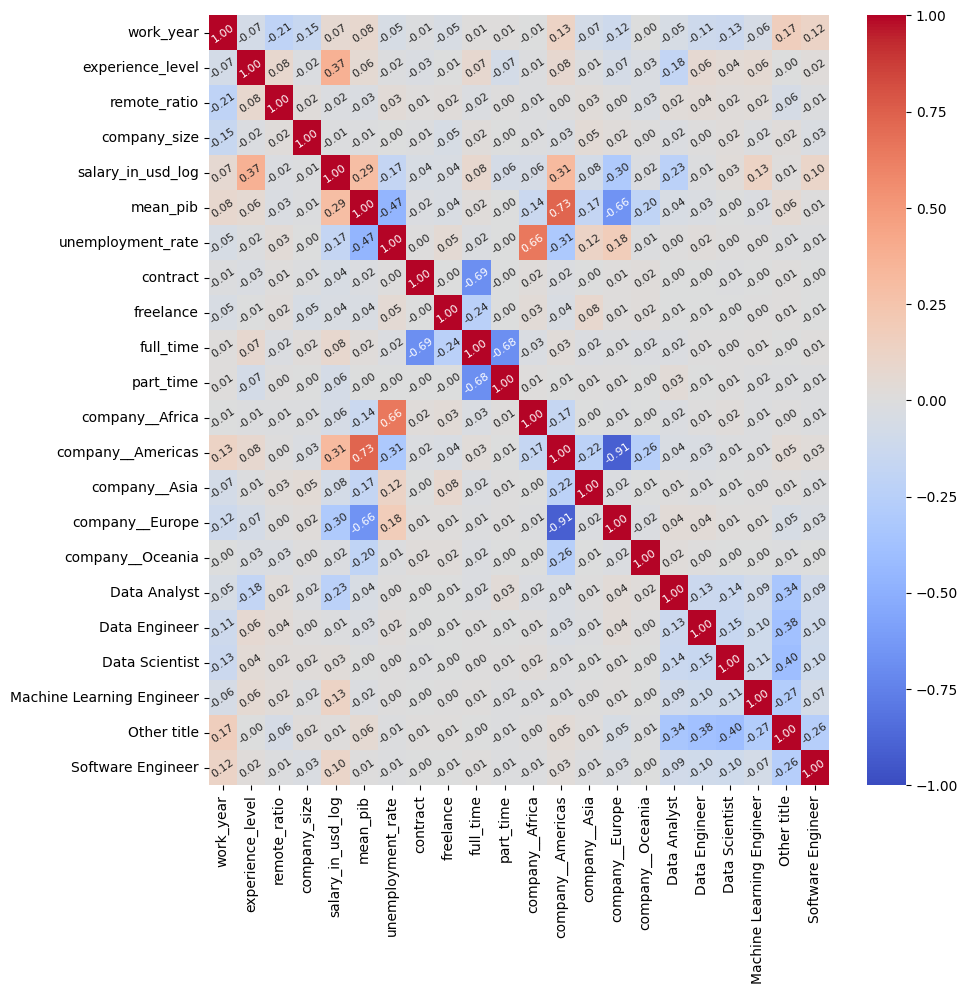

In [99]:
plt.figure(figsize=(10,10))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, fmt='.2f' , cmap="coolwarm");

## 6. salary_currency

In [127]:
salaries_df[salaries_df[["salary_currency", "company_country", "employee_country"]]["company_country"] != salaries_df[["salary_currency", "company_country", "employee_country"]]["employee_country"]].loc[:, ["salary_currency", "company_country", "employee_country"]]

,salary_currency,company_country,employee_country
6787,USD,United States,Poland
9273,EUR,Germany,Luxembourg
17525,USD,Poland,Ukraine
18140,USD,Algeria,Bermuda
19216,USD,United States,India
...,...,...,...
27959,USD,France,United States
27960,USD,United States,Russia
27968,EUR,Luxembourg,France
27978,USD,United States,Spain


No vemos que haya una relación clara entre la divisa del salario pagado y la localización de la empresa o el país del empleado. Si nos fijamos en la tabla previa, vemos:

- Un registro con un empleado de Polonia cuya empresa está en EEUU, y cobra en dólares
- Un registro con un empleado de Ucrania cuya empresa está en Polonia, y cobra en dólares
- Un registro con un empleado de EEUU cuya empresa está en Francia, y cobra en dólares
- Etc.

Así pues, vamos a intentar sacar alguna variable dummy a partir del campo de la divisa que nos pueda servir como predictora.

In [128]:
salaries_df["salary_currency"].value_counts(normalize=True).sort_values(ascending=False)

salary_currency
USD    0.928043
GBP    0.039123
EUR    0.023652
CAD    0.005002
INR    0.000929
CHF    0.000750
PLN    0.000572
AUD    0.000500
SGD    0.000286
BRL    0.000250
JPY    0.000214
ILS    0.000107
MXN    0.000071
NOK    0.000071
HUF    0.000071
ZAR    0.000071
DKK    0.000071
HKD    0.000036
CZK    0.000036
NZD    0.000036
SEK    0.000036
PHP    0.000036
CLP    0.000036
Name: proportion, dtype: float64

Fijándonos en el output previo, vemos que para la divisa del salario pagado:
- El dólar representa alrededor del 92%
- La libra esterlina representa alrededor del 4%
- El euro representa alrededor del 2%
- El otro 2% restante viene informado con diferentes divisas

Por ello, vamos a hacer estas 4 agrupaciones

In [ ]:
salaries_df["USD_salary"] = np.where(salaries_df["salary_currency"] == "USD", 1, 0)
salaries_df["GBP_salary"] = np.where(salaries_df["salary_currency"] == "GBP", 1, 0)
salaries_df["EUR_salary"] = np.where(salaries_df["salary_currency"] == "EUR", 1, 0)
salaries_df["Other_salary"] = np.where((salaries_df["salary_currency"]!= "USD") & (salaries_df["salary_currency"]!= "GBP") & (salaries_df["salary_currency"]!= "EUR"), 1, 0)

### Mapa de calor (VII)

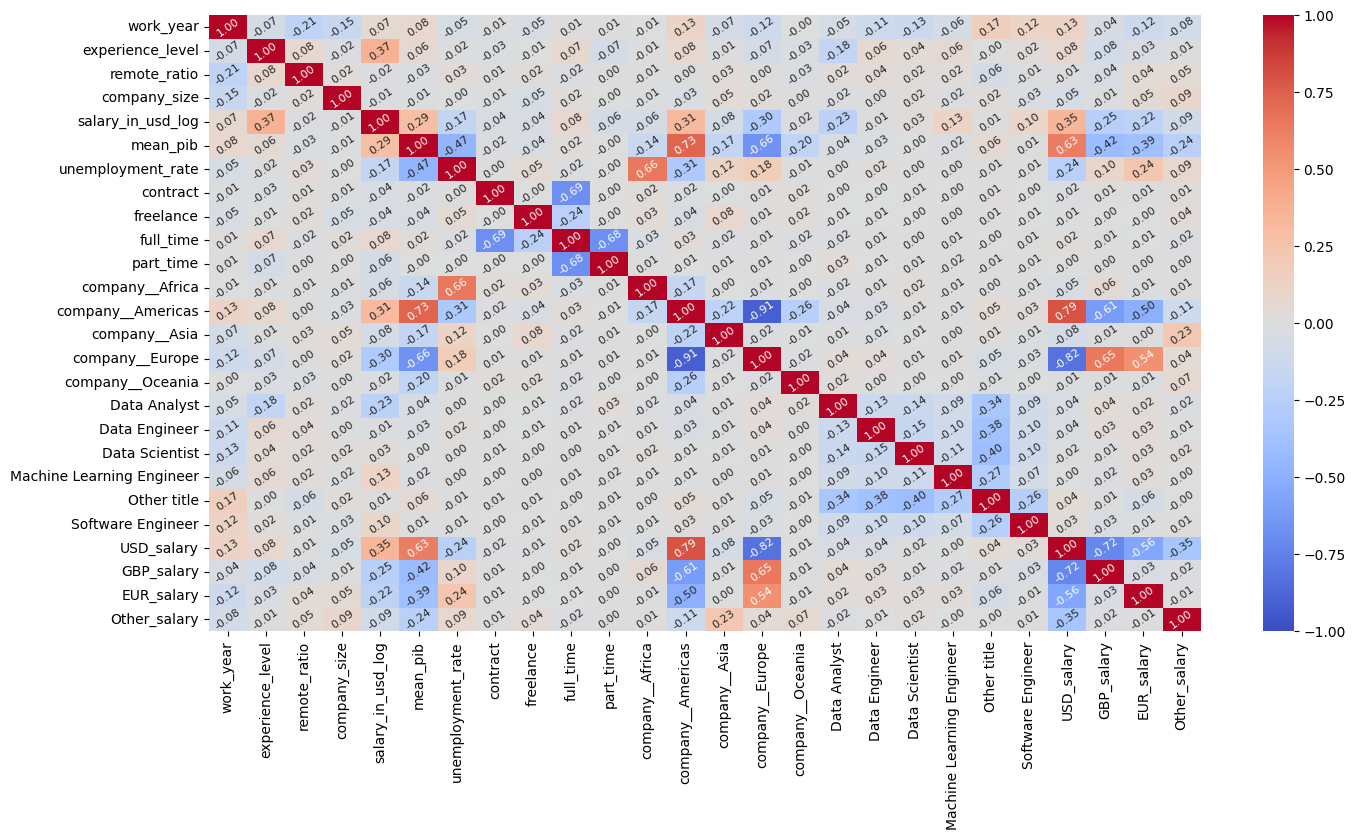

In [129]:
plt.figure(figsize=(16,8))
sns.heatmap(salaries_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8, 'rotation': 35}, fmt='.2f', cmap="coolwarm"); 

# DF FINAL

In [130]:
#Guardamos la tabla de salarios que tenemos con el análisis hecho hasta ahora
salaries_df.to_csv("data/processed/salaries_final_v1.csv", index=False)